# Section 2 - Probabilistic machine learning
Only concepts relevant to diffusion model.

TODO:
* MLE
* MAP
* Bayesian inference
* Information theory
* KL-divergence
* ELBO
* Variational inference
* Bias-variance tradeoff

In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm, invgamma
from scipy.stats import pearsonr
from scipy.stats import multivariate_normal
import networkx as nx
import warnings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')
np.random.seed(0)

## Outline

## Maximum likelihood
Maximum likelihood tries to maximize the likelihood (think of the likelihood in bayes) by finding the parameters for a distribution that fits well to the data. This is a point estimate, because it only finds the parameters that gives the highest probability of the parameters given the data. I think originally what you want is 

$$L(\theta, X) = P(\theta|X)$$

where X is the data. But we can conveniently use baye's theorem here to flip the condition to make it easier to calculate the maximum point

$$P(\theta|X) = \frac{P(X|\theta)P(\theta)}{P(X)} \propto P(X|\theta) $$

in MLE we only care about the optimum points in the likelihood, the prior is set to 1, so it doesn't affect anything and thus is ignored. The proportional sign is there to indicate a proportional relation, k * p, where k is some constant factor. The obejective there becomes to find

$$\theta_{opt} = \underset{\theta}{\operatorname{argmax}}L(X|\theta)$$
 
What you do in practice I think is you pick a distribution beforehand to fit the data and try to maximize this $P(X|\theta)$ likelihood by find the optimal parameters. If doing by hand you would usually just take the derivative of that likelihood w.r.t the parameters and hope that they have a nice analytical form. Otherwise, use a computer. 

To illustrate what MLE does in the parameter space, it's a point estimate, so it only finds the optimum parameters that gives the highest probability $P(X|\theta)$ and therefore $P(\theta|X)$

![](assets/mle.png)

The image shows the MLE for both discrete and continuous cases, i.e. when you are working with probability masses or probability densities. Here the x-axis is the parameters, and because we are only looking at the highest probability for the likelihood we therefore pick the parameters for that purpose.
Note that because we are not using any priors to ground the estimates, that means MLE tends to overfit to the data if no other additional regularization is in place.

**Why drop the normalizing constant and prior in baye's theorem?**
\
Because the normalizing constant (the denominator in baye's theorem) just scales the likelihood down, but since it's not dependent on the parameters, then it will not change the location of the maximum point. I've shown a simple example of that in the concepts notebook section 4 random variables, so you can take a look there if you want. As for the prior MLE doesn't care about priors, I think that's just the way they defined it, becaues you also have MAP that is like MLE but with prior included. I think the point is that sometimes MAP can be more expensive than a simple MLE because you need some informative prior, which can be hard to find sometimes. So instead with MLE we just choose not to deal with it at all, whether it's easy or hard to find it, and try to maximize the likelihood only. 

Here's a simple example with data generated from a gaussian with 5 mean and std 2. We use a gaussian to fit the data with MLE.

MLE for mu: 5.151515151515151
MLE for sigma: 2.0303030303030307


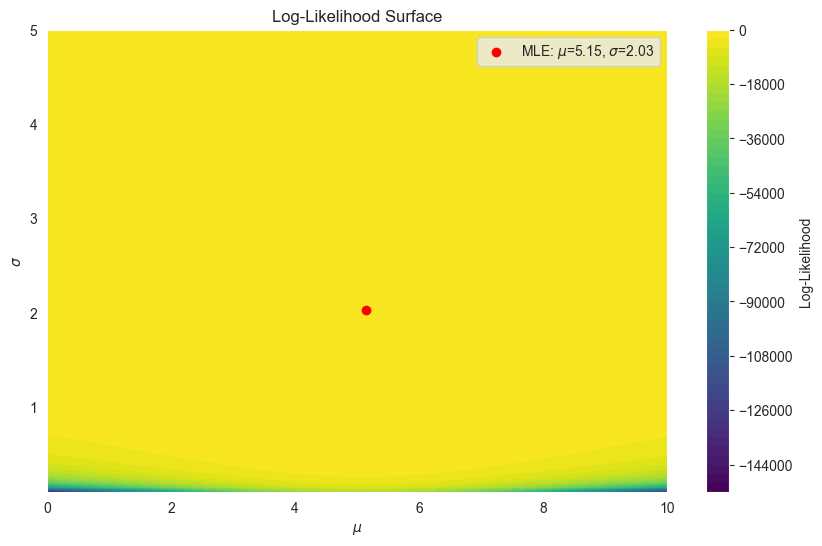

In [2]:
# Generate some data
np.random.seed(0)
data = np.random.normal(loc=5, scale=2, size=100)

# Function to compute the log-likelihood
def log_likelihood(mu, sigma, data):
    n = len(data)
    return -n/2 * np.log(2 * np.pi * sigma**2) - (1/(2 * sigma**2)) * np.sum((data - mu)**2)

# Grid search to evaluate log-likelihood over a range of mu and sigma values
mu_values = np.linspace(0, 10, 100)
sigma_values = np.linspace(0.1, 5, 100)
log_likelihood_values = np.zeros((len(mu_values), len(sigma_values)))

for i, mu in enumerate(mu_values):
    for j, sigma in enumerate(sigma_values):
        log_likelihood_values[i, j] = log_likelihood(mu, sigma, data)

# Find the MLE
max_ll_index = np.unravel_index(np.argmax(log_likelihood_values), log_likelihood_values.shape)
mle_mu = mu_values[max_ll_index[0]]
mle_sigma = sigma_values[max_ll_index[1]]

# Plotting the log-likelihood surface
plt.figure(figsize=(10, 6))
plt.contourf(mu_values, sigma_values, log_likelihood_values.T, levels=50, cmap='viridis')
plt.colorbar(label='Log-Likelihood')
plt.scatter(mle_mu, mle_sigma, color='red', label=f'MLE: $\mu$={mle_mu:.2f}, $\sigma$={mle_sigma:.2f}')
plt.xlabel('$\mu$')
plt.ylabel('$\sigma$')
plt.legend()
plt.title('Log-Likelihood Surface')

print(f"MLE for mu: {mle_mu}")
print(f"MLE for sigma: {mle_sigma}")
plt.show();

ChatGPT didn't crank out a good visualization here, but I don't have much time to fix this.
So here we are trying to find the optimal parameters $\mu$ and $\sigma$ for a univariate gaussian distribution. The data is originally generated from a gaussian with mean 5 and std 2. It approximates it quite well. One can also do this analytically and the derivations would have looked like this

$$L(\mu, \sigma | x_1, x_2, \ldots, x_n) = \prod_{i=1}^{n} \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{(x_i - \mu)^2}{2\sigma^2} \right)$$

We choose to work with the log likelihood to make computations easier

$$
\begin{align}
\ell(\mu, \sigma | x_1, x_2, \ldots, x_n)
&= \log L(\mu, \sigma | x_1, x_2, \ldots, x_n) \\
&= \sum_{i=1}^{n} \left( -\frac{1}{2} \log(2 \pi \sigma^2) - \frac{(x_i - \mu)^2}{2\sigma^2} \right) \\
&= -\frac{n}{2} \log(2 \pi) - \frac{n}{2} \log(\sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^{n} (x_i - \mu)^2 \\ 
\end{align}
$$

Now we take the derivative w.r.t $\mu$ and $\sigma$

Solving for $\mu$
$$
\frac{\partial \ell}{\partial \mu} = \frac{1}{\sigma^2} \sum_{i=1}^{n} (x_i - \mu) = 0 \implies \hat{\mu} = \frac{1}{n} \sum_{i=1}^{n} x_i
$$

Solving for $\sigma$
$$
\frac{\partial \ell}{\partial \sigma^2} = -\frac{n}{2\sigma^2} + \frac{1}{2\sigma^4} \sum_{i=1}^{n} (x_i - \mu)^2 = 0 \implies \hat{\sigma}^2 = \frac{1}{n} \sum_{i=1}^{n} (x_i - \hat{\mu})^2
$$

Now we have general formulas to compute the exact optimal mean and sigma. If we just input the data, that is what we will get.


## Maximum a priori
This is like MLE but with prior

$$P(\theta|X) = \frac{P(X|\theta)P(\theta)}{P(X)} \propto P(X|\theta)P(\theta)$$

$$L(\theta|X) = P(X|\theta)P(\theta)$$

Our objective becomes

$$\theta_{opt} = \underset{\theta}{\operatorname{argmax}}P(X|\theta)P(\theta)$$ 

No time, so I will skip going through this mathematically, but here's a code example.

MAP for mu: 5.151515151515151
MAP for sigma: 1.9397490205246304


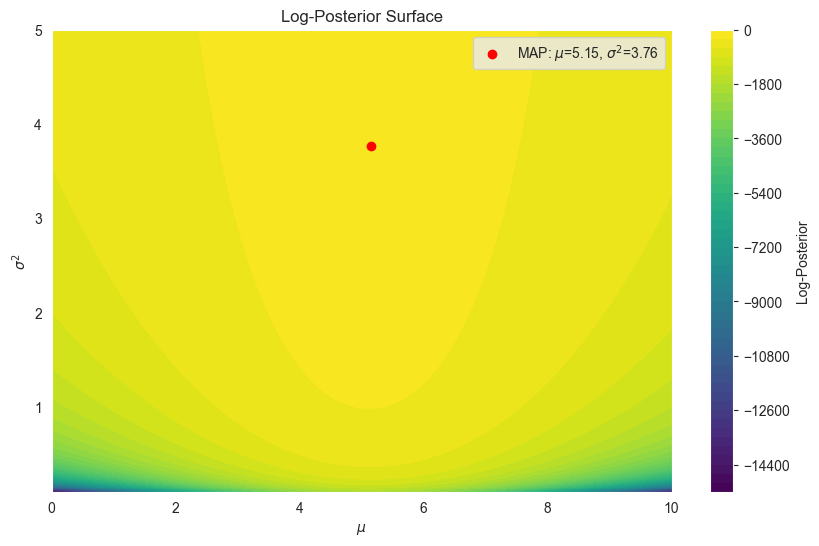

In [3]:
# Generate some data
np.random.seed(0)
data = np.random.normal(loc=5, scale=2, size=100)

# Prior parameters
mu_0 = 5
tau = 1
alpha = 3
beta = 1

# Function to compute the log-posterior
def log_posterior(mu, sigma2, data, mu_0, tau, alpha, beta):
    n = len(data)
    ll = -n/2 * np.log(2 * np.pi * sigma2) - (1/(2 * sigma2)) * np.sum((data - mu)**2)
    prior_mu = -0.5 * np.log(2 * np.pi * tau**2) - (mu - mu_0)**2 / (2 * tau**2)
    prior_sigma2 = alpha * np.log(beta) - np.log(np.math.gamma(alpha)) - (alpha + 1) * np.log(sigma2) - beta / sigma2
    return ll + prior_mu + prior_sigma2

# Grid search to evaluate log-posterior over a range of mu and sigma2 values
mu_values = np.linspace(0, 10, 100)
sigma2_values = np.linspace(0.1, 5, 100)
log_posterior_values = np.zeros((len(mu_values), len(sigma2_values)))

for i, mu in enumerate(mu_values):
    for j, sigma2 in enumerate(sigma2_values):
        log_posterior_values[i, j] = log_posterior(mu, sigma2, data, mu_0, tau, alpha, beta)

# Find the MAP
max_lp_index = np.unravel_index(np.argmax(log_posterior_values), log_posterior_values.shape)
map_mu = mu_values[max_lp_index[0]]
map_sigma2 = sigma2_values[max_lp_index[1]]
map_sigma = np.sqrt(map_sigma2)

# Plotting the log-posterior surface
plt.figure(figsize=(10, 6))
plt.contourf(mu_values, sigma2_values, log_posterior_values.T, levels=50, cmap='viridis')
plt.colorbar(label='Log-Posterior')
plt.scatter(map_mu, map_sigma2, color='red', label=f'MAP: $\mu$={map_mu:.2f}, $\sigma^2$={map_sigma2:.2f}')
plt.xlabel('$\mu$')
plt.ylabel('$\sigma^2$')
plt.legend()
plt.title('Log-Posterior Surface')

print(f"MAP for mu: {map_mu}")
print(f"MAP for sigma: {map_sigma}")

plt.show();

Pretty close to the original distribution parameters. The thing is one can show that the prior works like a regularizer.

## Bayesian inference

## Basic self information and entropy
I usually think of this as bits, which to me means outcomes. I will present the basic definitions of self-information and entropy and go over the idea of bits as encoding outcomes. I think this interpretation is the most helpful in understanding entropy.

Definition of entropy
$$$$